In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.retinotopy import convert_coords as coords

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import retino_structure as ret
from pipeline.python.classifications import rf_utils as rfutils

from pipeline.python.classifications import aggregate_data_stats as aggr

from pipeline.python.utils import natural_keys, label_figure, convert_range

from matplotlib.lines import Line2D


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/fit_2d_rfs.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/get_traces.py:96: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  Fi

In [2]:
%matplotlib notebook


# Set color schemes by visual area

In [3]:
# visual_areas = ['V1', 'Lm', 'Li']
# colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
# area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}
visual_areas = ['V1', 'Lm', 'Li']
colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

#### Plot params
pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

dpi = 150

In [4]:
# def set_split_xlabels(ax, offset=0.25, a_label='rfs', b_label='rfs10'):
#     ax.set_xticks([0-offset, 0+offset, 1-offset, 1+offset, 2-offset, 2+offset])
#     ax.set_xticklabels([a_label, b_label, a_label, b_label, a_label, b_label])
#     ax.set_xlabel('')
#     ax.tick_params(axis='x', size=0)
#     sns.despine(bottom=True, offset=4)
#     return ax

# Set dataset parameters

In [5]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Preprocessing params
responsive_test = None
responsive_thr = None
n_stds = None

#### RF fit params
response_type = 'dff'
fit_thr=0.5

#### Set outputdir for current analysis
fit_desc = fitrf.get_fit_desc(response_type=response_type)
outdir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, fit_desc))
if not os.path.exists(outdir):
    os.makedirs(outdir)
print("... saving output to base dir:\n%s" % outdir)

#### Create data ID for labeling figures with data-types
data_desc = '%s-%s' % (traceid, fit_desc)
data_id = '|'.join([data_desc, '%s-thr-%.2f' % (fit_desc, fit_thr)])
print("DATA ID: %s" % data_id)

... saving output to base dir:
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff
DATA ID: traces001-fit-2dgaus_dff-no-cutoff|fit-2dgaus_dff-no-cutoff-thr-0.50


# Control: check 'rfs' vs. 'rfs10'

In [7]:
#### Create current output dir
compare_dir = os.path.join(outdir, 'general-stats', 'rfs_v_rfs10')
if not os.path.exists(compare_dir):
    os.makedirs(compare_dir)
print compare_dir

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10


#### Load data

In [8]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)

In [9]:
# Get data sets where rfs and rfs10 were tested
ctl_dsets = pd.concat([dg[dg['experiment'].isin(['rfs', 'rfs10'])] for dkey, dg in sdata.groupby(['animalid', 'session', 'fovnum']) \
            if ('rfs' in dg['experiment'].values and 'rfs10' in dg['experiment'].values)], axis=0).reset_index(drop=True)
ctl_dsets.groupby(['visual_area'])['experiment'].value_counts()

visual_area  experiment
Li           rfs           4
             rfs10         4
Lm           rfs           1
             rfs10         1
V1           rfs           4
             rfs10         4
Name: experiment, dtype: int64

In [11]:
ctl_dsets.groupby(['visual_area', 'experiment', 'animalid', 'session', 'fovnum']).count()

fov
visual_area experiment animalid session  fovnum     
Li          rfs        JC089    20190522 1         1
                       JC091    20190602 1         1
                                20191007 1         1
                       JC113    20191017 1         1
            rfs10      JC089    20190522 1         1
                       JC091    20190602 1         1
                                20191007 1         1
                       JC113    20191017 1         1
Lm          rfs        JC097    20190618 1         1
            rfs10      JC097    20190618 1         1
V1          rfs        JC085    20190622 1         1
                       JC097    20190613 1         1
                                20190616 1         1
                       JC110    20191006 1         1
            rfs10      JC085    20190622 1         1
                       JC097    20190613 1         1
                                20190616 1         1
                       JC110    20191006 1         1

In [54]:
# Aggregate all fit data into dataframe
scale_sigma = True
reliable_only = True

dpaths, _ = rfutils.get_fit_dpaths(ctl_dsets, fit_desc=fit_desc, traceid=traceid,) # get datapths
tmpdf = rfutils.aggregate_rf_data(dpaths,  fit_desc=fit_desc, traceid=traceid,
                                  reliable_only=reliable_only,
                                  fit_thr=fit_thr, scale_sigma=scale_sigma, verbose=False) # load dataframes
df = tmpdf[tmpdf['r2']>fit_thr] # Filter to make sure all good fits

df.groupby(['visual_area', 'experiment']).count()


N dpaths: 18, N unfit: 0
N datasets included: 18, N sessions excluded: 0


r2  fwhm_x  fwhm_y  theta   x0   y0  animalid  cell  \
visual_area experiment                                                         
Li          rfs          75      75      75     75   75   75        75    75   
            rfs10       127     127     127    127  127  127       127   127   
Lm          rfs          14      14      14     14   14   14        14    14   
            rfs10        28      28      28     28   28   28        28    28   
V1          rfs         244     244     244    244  244  244       244   244   
            rfs10       440     440     440    440  440  440       440   440   

                        datakey  fovnum  session  std_x  std_y  fwhm_avg  \
visual_area experiment                                                     
Li          rfs              75      75       75     75     75        75   
            rfs10           127     127      127    127    127       127   
Lm          rfs              14      14       14     14     14        14   
            rfs10            28      28       28     28     28        28   
V1          rfs             244     244      244    244    244       244   
            rfs10           440     440      440    440    440       440   

                        std_avg  area  
visual_area experiment                 
Li          rfs              75    75  
            rfs10           127   127  
Lm          rfs              14    14  
            rfs10            28    28  
V1          rfs             244   244  
            rfs10           440   440

In [57]:
df.shape

(928, 18)

In [63]:
df.head()

,r2,fwhm_x,fwhm_y,theta,x0,y0,animalid,cell,datakey,experiment,fovnum,session,visual_area,std_x,std_y,fwhm_avg,std_avg,area
0,0.631459,45.961738,34.231365,0.216454,1.111327,5.854219,JC089,85,20190522_JC089_fov1,rfs,1,20190522,Li,19.558186,14.566538,40.096552,17.062362,895.024271
1,0.520312,39.363302,31.265255,5.491278,-0.359113,25.227100,JC089,115,20190522_JC089_fov1,rfs,1,20190522,Li,16.750341,13.304364,35.314278,15.027352,700.112194
2,0.559490,31.689496,36.726462,6.074524,3.931988,24.304596,JC089,122,20190522_JC089_fov1,rfs,1,20190522,Li,13.484892,15.628282,34.207979,14.556587,662.077125
0,0.585001,46.670332,36.780253,6.081151,-29.065480,-11.080597,JC089,71,20190522_JC089_fov1,rfs10,1,20190522,Li,19.859716,15.651172,41.725293,17.755444,976.494391
1,0.696801,45.149795,27.452993,0.127034,13.248381,-21.937449,JC089,89,20190522_JC089_fov1,rfs10,1,20190522,Li,19.212679,11.682125,36.301394,15.447402,705.114482


In [64]:
df[['visual_area', 'experiment', 'datakey']].drop_duplicates().groupby(['visual_area', 'experiment']).count()

datakey
visual_area experiment         
Li          rfs               4
            rfs10             4
Lm          rfs               1
            rfs10             1
V1          rfs               4
            rfs10             4

In [21]:
reload(rfutils)

<module 'pipeline.python.classifications.rf_utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/rf_utils.py'>

## Check size of RFs by x/y

In [65]:
fx = abs(df[['std_x', 'std_y']].max(axis=1) * np.cos(df['theta']))
fy = abs(df[['std_x', 'std_y']].max(axis=1) * np.sin(df['theta']))

df['fx'] = fx
df['fy'] = fy

<IPython.core.display.Javascript object>


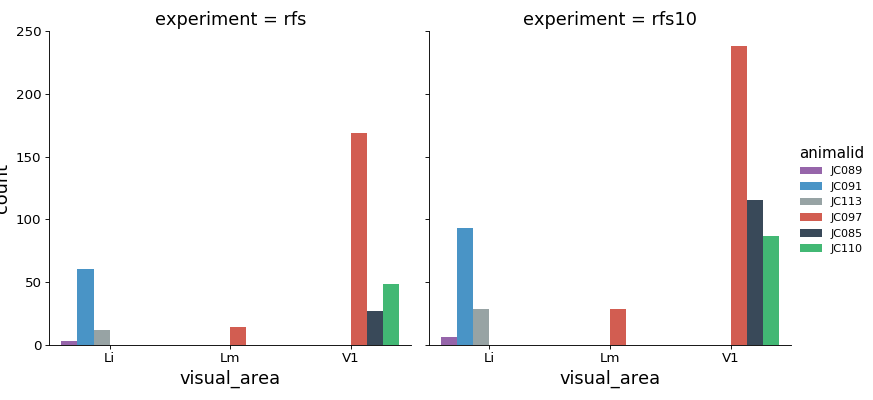

,r2,fwhm_x,fwhm_y,theta,x0,y0,animalid,cell,datakey,experiment,fovnum,session,std_x,std_y,fwhm_avg,std_avg,area,fx,fy
visual_area,,,,,,,,,,,,,,,,,,,
Li,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202
Lm,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42
V1,684,684,684,684,684,684,684,684,684,684,684,684,684,684,684,684,684,684,684


In [66]:
sns.catplot(x='visual_area', hue='animalid', col='experiment',  data=df, kind='count')
df.groupby(['visual_area']).count()

## Test: x + y components of vector spanned by ellipse (major)

In [67]:
datakey = '20190622_JC085_fov1'
rid=25
sz_metric = 'std'

#params=['r2', 'sigma_x', 'sigma_y', 'theta', 'x0', 'y0', 'datakey', 'cell', 'experiment', 'avg_size', 'fx', 'fy']
params=['r2', '%s_x' % sz_metric, '%s_y' % sz_metric, 'theta', 
        'x0', 'y0', 'datakey', 'cell', 'experiment', '%s_avg' % sz_metric, 'fx', 'fy']

df[(df['datakey']==datakey) & (df['cell']==rid)][params]

,r2,std_x,std_y,theta,x0,y0,datakey,cell,experiment,std_avg,fx,fy
9,0.663539,8.261852,11.873748,5.714767,35.90598,-4.720554,20190622_JC085_fov1,25,rfs10,10.0678,10.006644,6.391632


237.777484979


<IPython.core.display.Javascript object>


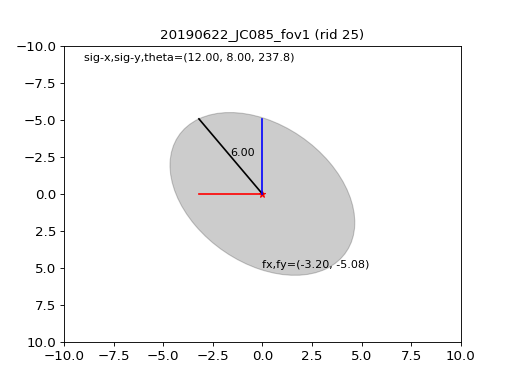

(-3.2, -5.08)


In [16]:
from matplotlib.patches import Ellipse

x0, y0 = (0, 0)
M = 12 #10
m = 8 #3

theta = np.rad2deg(4.15)
print(theta)
angle = np.deg2rad(theta)

fig, ax = pl.subplots() #pl.figure()
ax.plot(x0, y0, 'r*')

el = Ellipse((x0, y0), width=M, height=m, angle=theta, alpha=0.2, color='k')
ax.add_artist(el)


ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])

F = M/2.

xe = F * np.cos(np.deg2rad(theta))
ye = F * np.sin(np.deg2rad(theta))
ax.plot([x0, xe], [y0, ye], 'k')
ax.text(xe/2., ye/2., '%.2f' % F)

fx = round(F * np.cos(np.deg2rad(theta)), 2)
fy = round(F * np.sin(np.deg2rad(theta)), 2)
print(fx, fy)

ax.text(0, 5, 'fx,fy=(%.2f, %.2f)' % (fx, fy))
ax.text(-9, -9, 'sig-x,sig-y,theta=(%.2f, %.2f, %.1f)' % (M, m, theta))
ax.plot([x0, fx], [y0, y0], 'r')
ax.plot([x0, x0], [y0, fy], 'b')


ax.set_title('%s (rid %i)' % (datakey, rid))

ax.invert_yaxis()

## Plot x- and y-components of fit RFs

<IPython.core.display.Javascript object>


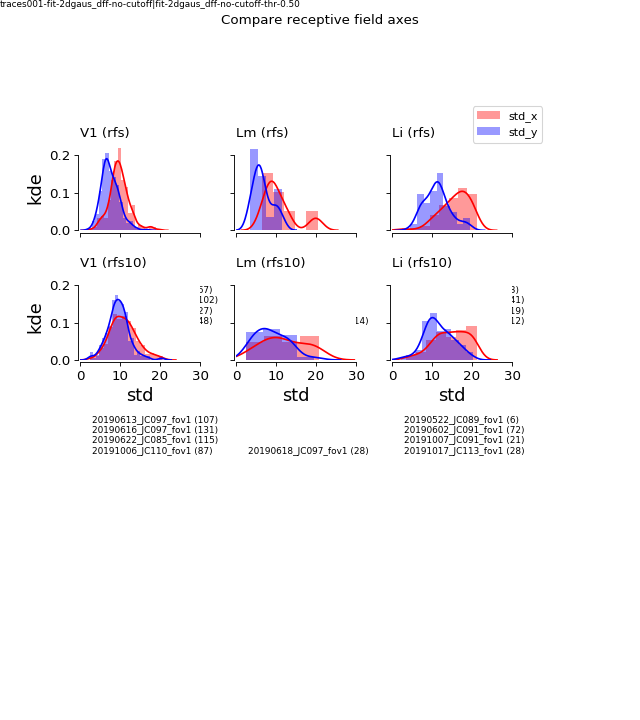

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10_2', 'split_std_xy_std')


In [68]:
split_components = False
experiment = 'rfs10'

x_color = 'r'
y_color = 'b'

#_df = df[df['experiment']==experiment].copy()

xlim = 60 if sz_metric=='fwhm' else 30
component_str = 'f' if split_components else '%s_' % sz_metric

visual_areas = ['V1', 'Lm', 'Li']


offset=0
fig, axes = pl.subplots(2,3, figsize=(8,9), sharey=True, sharex=True)
pl.subplots_adjust(wspace=0.3, right=0.8, top=0.8, bottom=0.5)

for ri, (experiment, edf) in enumerate(df.groupby(['experiment'])):
    for ci, visual_area in enumerate(visual_areas):
        ax = axes[ri, ci]
        if ci==0:
            ax.set_ylabel('kde')
    #for ax, visual_area in zip(axes.flat, visual_areas):
        g = edf[edf['visual_area']==visual_area].copy()

        sns.distplot(g['%sx' % component_str], color=x_color, ax=ax, label='%sx' % component_str)
        sns.distplot(g['%sy' % component_str], color=y_color, ax=ax, label='%sy' % component_str)
        ax.set_title('%s (%s)' % (visual_area, experiment), loc='left')
        count_str = '\n'.join(['%s (%i)' % (dkey, len(d)) for dkey, d in g.groupby(['datakey'])])
        #ax.set_ylim([0, 0.1])
        ax.set_xlim([0, xlim])
        ax.text(3, -0.25, count_str, fontsize=8)
        if ri==1:
            ax.set_xlabel(sz_metric)
        else:
            ax.set_xlabel('')

sns.despine(trim=True, offset=2)
    
ax.legend(bbox_to_anchor=(1.3, 3))

label_figure(fig, data_id)
fig.suptitle('Compare receptive field axes')
pl.subplots_adjust(hspace=0.5)
figname = 'split_%sxy_%s' % (component_str, sz_metric)
pl.savefig(os.path.join(compare_dir, '%s_2.svg' % figname))
print(compare_dir, figname)

# Get cells fit for BOTH rfs and rfs10

In [42]:
# def pairwise_compare_single_metric(comdf, curr_metric='avg_size', ax=None, marker='o'):

#     offset = 0.25
    
#     if ax is None:
#         fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
#         fig.patch.set_alpha(0)
#         ax.patch.set_alpha(0)
    
#     # Plot paired values
#     aix=0
#     for ai, visual_area in enumerate(visual_areas):

#         plotdf = comdf[comdf['visual_area']==visual_area]
#         a_vals = plotdf[plotdf['experiment']=='rfs'].sort_values(by='datakey')[curr_metric].values
#         b_vals = plotdf[plotdf['experiment']=='rfs10'].sort_values(by='datakey')[curr_metric].values

#         by_exp = [(a, e) for a, e in zip(a_vals, b_vals)]
#         for pi, p in enumerate(by_exp):
#             ax.plot([aix-offset, aix+offset], p, marker=marker, color=area_colors[visual_area], 
#                     alpha=1, lw=0.5,  zorder=0, markerfacecolor=None, markeredgecolor=area_colors[visual_area])
#         tstat, pval = spstats.ttest_rel(a_vals, b_vals)
#         print("%s: (t-stat:%.2f, p=%.2f)" % (visual_area, tstat, pval))
#         aix = aix+1

#     # Plot average
#     sns.barplot("visual_area", curr_metric, data=comdf, 
#                 hue='experiment', #zorder=0,
#                 ax=ax, order=visual_areas,
#                 errcolor="k", edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
#     ax.legend_.remove()

#     set_split_xlabels(ax, a_label='rfs', b_label='rfs10')
    
#     return ax


In [69]:
curr_metric = 'std_avg'
common_rois = dict((dkey, np.intersect1d(d[d['experiment']=='rfs']['cell'], d[d['experiment']=='rfs10']['cell']))\
                     for dkey, d in df.groupby(['datakey']))

comdf = []
for visual_area, vdf in df.groupby(['visual_area']):
    currdf = pd.concat([g[g['cell'].isin(common_rois[dkey])] \
                        for dkey, g in vdf.groupby(['datakey'])], axis=0)

    a_vals = currdf[currdf['experiment']=='rfs'][curr_metric]
    b_vals = currdf[currdf['experiment']=='rfs10'][curr_metric]

    comdf.append(currdf)
    print("-----%s-------------------------" % visual_area)
    print("Paired t-test:")
    print spstats.ttest_rel(a_vals, b_vals) # Paired ttest (repeated measures)
    
    print("Wilcozon signed-rank (not assuming Gaussian):")
    print spstats.wilcoxon(a_vals, b_vals)   
    
comdf = pd.concat(comdf, axis=0)

-----Li-------------------------
Paired t-test:
Ttest_relResult(statistic=-1.973459454229745, pvalue=0.055379594732175616)
Wilcozon signed-rank (not assuming Gaussian):
WilcoxonResult(statistic=281.0, pvalue=0.052711780303207265)
-----Lm-------------------------
Paired t-test:
Ttest_relResult(statistic=-0.58579188185691067, pvalue=0.57241013840660804)
Wilcozon signed-rank (not assuming Gaussian):
WilcoxonResult(statistic=23.0, pvalue=0.64646220266416965)
-----V1-------------------------
Paired t-test:
Ttest_relResult(statistic=-10.796391392280237, pvalue=9.5789647349709622e-22)
Wilcozon signed-rank (not assuming Gaussian):
WilcoxonResult(statistic=2885.0, pvalue=5.0357797995083394e-19)


In [44]:
comdf.head()

,r2,fwhm_x,fwhm_y,theta,x0,y0,animalid,cell,datakey,experiment,fovnum,session,visual_area,std_x,std_y,fwhm_avg,std_avg,area,fx,fy
0,0.532335,40.932746,28.316740,0.285407,32.061522,-9.987968,JC091,15,20190602_JC091_fov1,rfs,1,20190602,Li,17.418190,12.049677,34.624743,14.733933,659.368636,16.713573,4.904061
1,0.723705,30.682715,19.030918,0.122968,30.405604,-7.293580,JC091,16,20190602_JC091_fov1,rfs,1,20190602,Li,13.056475,8.098263,24.856816,10.577369,332.175553,12.957885,1.601480
2,0.501710,30.976813,21.527211,0.367514,27.390515,-10.225962,JC091,24,20190602_JC091_fov1,rfs,1,20190602,Li,13.181622,9.160515,26.252012,11.171069,379.348738,12.301401,4.736107
3,0.709982,29.311060,24.789771,0.115117,31.994919,-7.388473,JC091,33,20190602_JC091_fov1,rfs,1,20190602,Li,12.472792,10.548839,27.050416,11.510815,413.350233,12.390239,1.432659
5,0.553642,32.808289,20.089325,0.317003,30.465034,-3.183316,JC091,36,20190602_JC091_fov1,rfs,1,20190602,Li,13.960974,8.548649,26.448807,11.254812,374.941125,13.265352,4.351922


## Average size by experiment-type (all fovs tested for control)

<IPython.core.display.Javascript object>


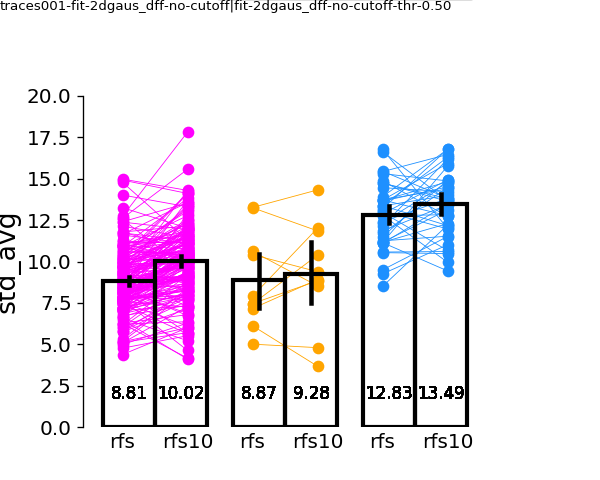

V1: (t-stat:-10.80, p=0.00)
Lm: (t-stat:-0.59, p=0.57)
Li: (t-stat:-1.97, p=0.06)
('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10_2', 'std_avg_pairwise_by-area')


In [45]:
sz_metric = 'std'

curr_metric = '%s_avg' % sz_metric


ylim = 60 if sz_metric=='fwhm' else 20.
offset = 0.25
marker= 'o'

fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax = rfutils.pairwise_compare_single_metric(comdf, curr_metric=curr_metric, ax=ax)

df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=10)
    
# Set x labels
ax.set_ylim([0, ylim])
rfutils.set_split_xlabels(ax, a_label='rfs', b_label='rfs10')


pl.subplots_adjust(left=0.15, right=0.8, top=0.8)
label_figure(fig, data_id)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(comdf, area_colors=area_colors, markersize=10, marker='_')
ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.5), fontsize=8)


figname = '%s_pairwise_by-area' % (curr_metric)
pl.savefig(os.path.join(compare_dir, '%s_2.svg' % figname))

print(compare_dir, figname)

In [46]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

formula = 'std_avg ~ C(experiment) * C(visual_area)'
model = ols(formula, data=comdf).fit()
aov_table = sm.stats.anova_lm(model, typ=3)
aov_table

,sum_sq,df,F,PR(>F)
Intercept,6748.176479,1.0,1622.359495,2.249304e-159
C(experiment),8.968590,1.0,2.156179,1.426237e-01
C(visual_area),554.466845,2.0,66.650935,2.131176e-26
C(experiment):C(visual_area),7.548833,2.0,0.907424,4.042232e-01
Residual,2088.060385,502.0,NaN,NaN


In [47]:
model = ols('std_avg ~ visual_area + experiment', comdf).fit()
print(model.summary()) 

                            OLS Regression Results                            
Dep. Variable:                std_avg   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     90.22
Date:                Mon, 17 Aug 2020   Prob (F-statistic):           9.63e-47
Time:                        10:41:18   Log-Likelihood:                -1080.8
No. Observations:                 508   AIC:                             2170.
Df Residuals:                     504   BIC:                             2186.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              12.6152    

In [48]:
print(model.f_test([0, 1, -1, 0]))

<F test: F=array([[ 0.54136391]]), p=0.462210301391, df_denom=504, df_num=1>


In [49]:
result = ols(formula='std_avg ~ visual_area + experiment + visual_area * experiment', data=comdf).fit()    
print(result.summary())    

                            OLS Regression Results                            
Dep. Variable:                std_avg   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     54.48
Date:                Mon, 17 Aug 2020   Prob (F-statistic):           3.57e-45
Time:                        10:41:30   Log-Likelihood:                -1079.9
No. Observations:                 508   AIC:                             2172.
Df Residuals:                     502   BIC:                             2197.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [60]:
# def annotateBars(row, ax=ax, fontsize=12): 
#     for p in ax.patches:
#         ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., 0.), #p.get_height()),
#                     ha='center', va='center', fontsize=fontsize, color='k', 
#                     rotation=0, xytext=(0, 20),
#              textcoords='offset points')
        
    

In [66]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

<IPython.core.display.Javascript object>


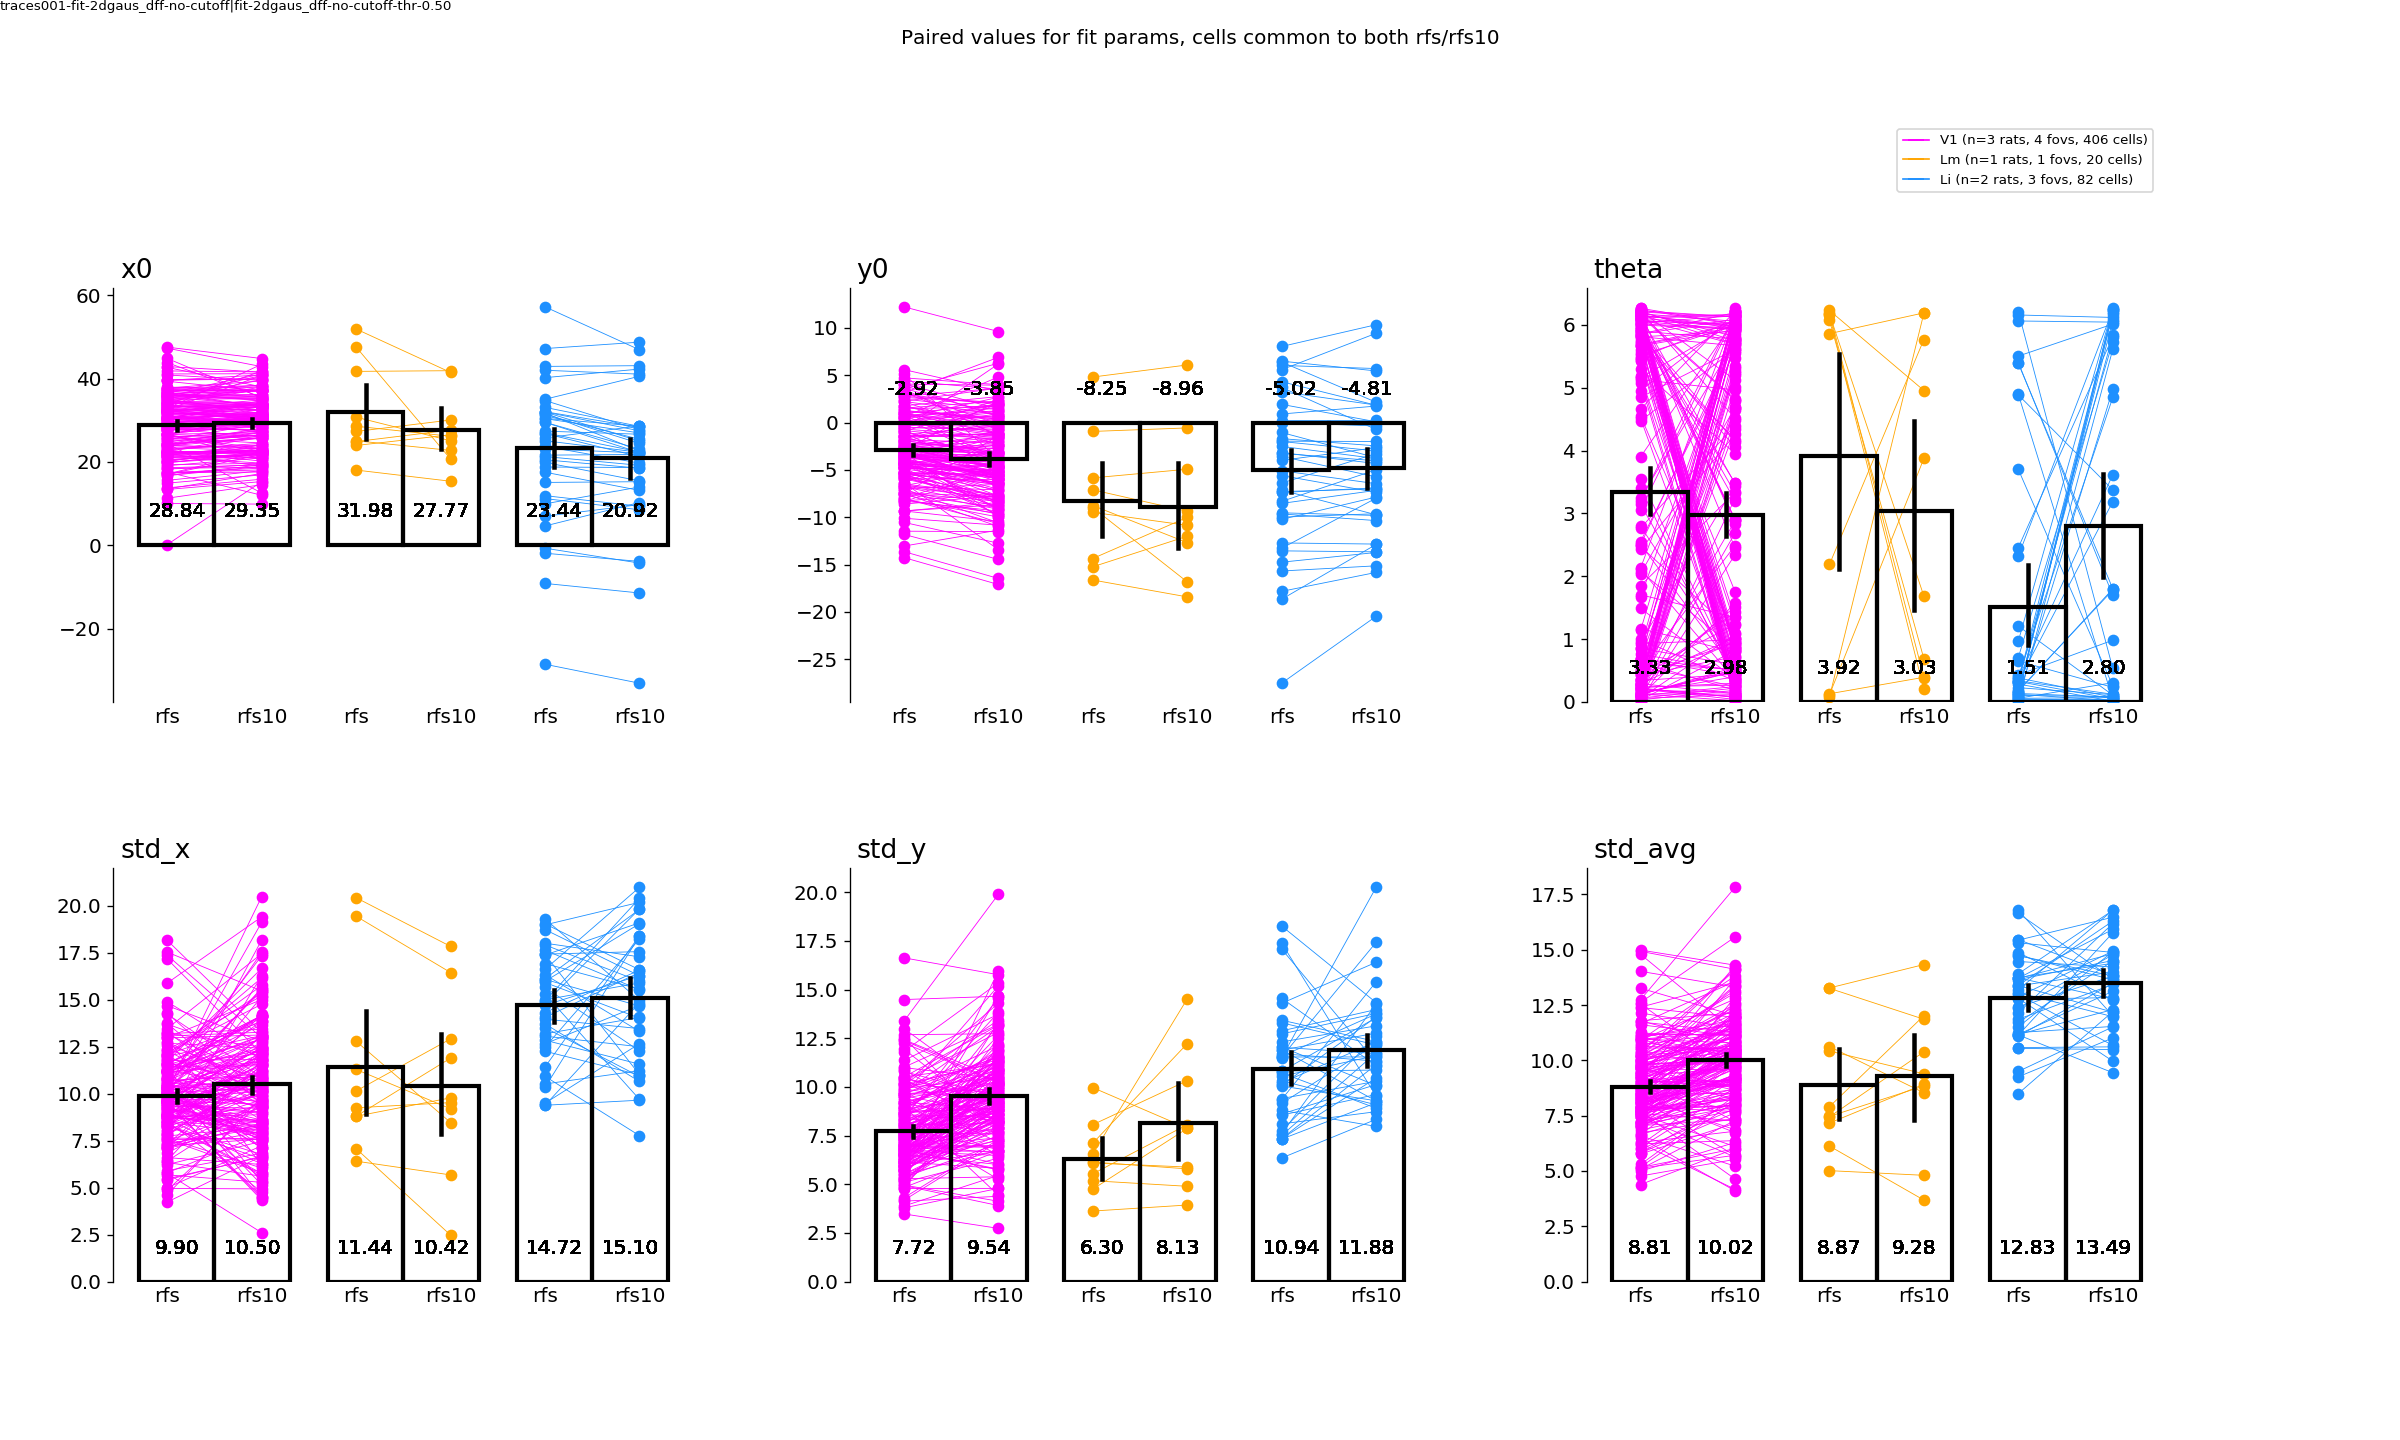

x0--------------
V1: (t-stat:-2.59, p=0.01)
Lm: (t-stat:1.48, p=0.17)
Li: (t-stat:4.32, p=0.00)
y0--------------
V1: (t-stat:5.91, p=0.00)
Lm: (t-stat:0.63, p=0.55)
Li: (t-stat:-0.54, p=0.59)
theta--------------
V1: (t-stat:1.38, p=0.17)
Lm: (t-stat:0.63, p=0.54)
Li: (t-stat:-2.56, p=0.01)
std_x--------------
V1: (t-stat:-2.92, p=0.00)
Lm: (t-stat:1.17, p=0.27)
Li: (t-stat:-0.71, p=0.48)
std_y--------------
V1: (t-stat:-11.27, p=0.00)
Lm: (t-stat:-1.93, p=0.09)
Li: (t-stat:-1.86, p=0.07)
std_avg--------------
V1: (t-stat:-10.80, p=0.00)
Lm: (t-stat:-0.59, p=0.57)
Li: (t-stat:-1.97, p=0.06)
('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10_2', 'fitparams_cells-common-to-both-condns_std')


In [50]:
#split_components = False
sz_metric = 'std'

offset = 0.25
marker= 'o'

params = ['x0', 'y0', 'theta', '%s_x' % sz_metric, '%s_y' % sz_metric, '%s_avg' % sz_metric]
#sz_metric = 'f' if split_components else 'sigma_'
#params.extend(['%sx' % sz_metric, '%sy' % sz_metric])
    

fig, axn = pl.subplots(2, 3, figsize=(20,12), dpi=dpi)
fig.patch.set_alpha(0)

for ax, curr_metric in zip(axn.flat, params):

    ax.patch.set_alpha(0)
    
    # Plot paired values
    print("%s--------------" % curr_metric)
    ax = rfutils.pairwise_compare_single_metric(comdf, curr_metric=curr_metric, ax=ax)
    
    ax.set_title(curr_metric, loc='left', fontsize=16)
    ax.set_ylabel('')

    # Annotate bars
    comdf.apply(aggr.annotateBars, ax=ax, axis=1)
    
# Adjust figure size
pl.subplots_adjust(left=0.05, right=0.9, top=0.8, wspace=0.3, hspace=0.4)
label_figure(fig, data_id)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(comdf, area_colors=area_colors, markersize=10, marker='_')
ax.legend(handles=legend_elements, bbox_to_anchor=(1, 2.8), fontsize=8)

fig.suptitle('Paired values for fit params, cells common to both rfs/rfs10')

# Save
figname = 'fitparams_cells-common-to-both-condns_%s' % (sz_metric)
pl.savefig(os.path.join(compare_dir, '%s.svg' % figname))

print(compare_dir, figname)    

In [124]:
# curr_metric = 'avg_size'

# fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
# fig.patch.set_alpha(0)
# ax.patch.set_alpha(0)

# ax = pairwise_compare_single_metric(comdf, curr_metric='avg_size', ax=ax)

# # Set x labels
# ax.set_ylim([0, 50])
    
# # Adjust figure size
# pl.subplots_adjust(left=0.12, right=0.7, top=0.8)
# label_figure(fig, data_id)

# # Get counts of samples for legend
# legend_elements = aggr.get_counts_for_legend(comdf, area_colors=area_colors, markersize=10, marker='_')
# ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.2), fontsize=8)

# # Save
# # figname = '%s_cells-common-to-both-condns' % curr_metric
# # pl.savefig(os.path.join(compare_dir, '%s.svg' % figname))

# # print(compare_dir, figname)    

# Check counts (N cells fit by experiment type)

<IPython.core.display.Javascript object>


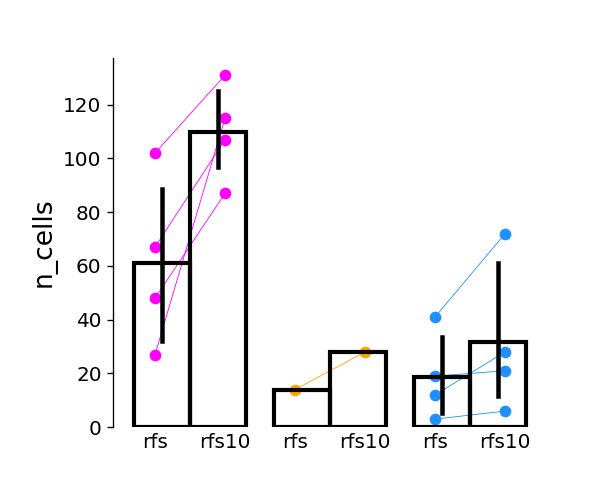

V1: (t-stat:-3.70, p=0.03)
Lm: (t-stat:nan, p=nan)
Li: (t-stat:-1.91, p=0.15)


In [70]:
countdf_all = df.groupby([ 'experiment', 'visual_area', 'animalid', 'datakey']).count()['cell'].reset_index()
countdf_all.rename(columns={'cell': 'n_cells'}, inplace=True)


curr_metric = 'n_cells'

fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax = rfutils.pairwise_compare_single_metric(countdf_all, curr_metric=curr_metric, ax=ax)
pl.subplots_adjust(left=0.2)
# Set x labels
#ax.set_ylim([0, 50])

#### Plot join between rfs/rfs10

<IPython.core.display.Javascript object>


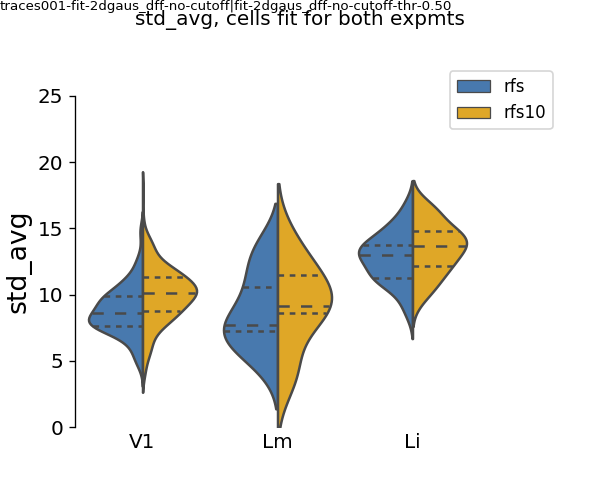

In [75]:
curr_metric = 'std_avg'

ylim = 50 if 'fwhm' in curr_metric else 25
currcols = ['windows blue', 'amber']
bi_palette = sns.xkcd_palette(currcols)

fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

sns.violinplot(x='visual_area', y=curr_metric, data=comdf, ax=ax,
               order=visual_areas,
              hue='experiment', palette=bi_palette, split=True,
               inner='quartile', scale='count')

ax.set_ylim([0, ylim])
ax.tick_params(axis='x', size=0)
ax.set_xlabel('')

fig.suptitle('%s, cells fit for both expmts' % curr_metric)
pl.subplots_adjust(right=0.8, top=0.8)
label_figure(fig, data_id)

ax.legend(bbox_to_anchor=(1.2, 1.1))
sns.despine(bottom=True, trim=True)

#### Calculate difference between rfs/rfs10 for size

In [125]:
# diffs = []
# for v, vdf in comdf.groupby(['visual_area']):
#     a_vals = vdf[vdf['experiment']=='rfs'][curr_metric].values
#     b_vals = vdf[vdf['experiment']=='rfs10'][curr_metric].values
#     diffs.append(pd.DataFrame({'visual_area': [v for _ in np.arange(0, len(a_vals))],
#                                'difference': b_vals - a_vals}))
# diffs = pd.concat(diffs, axis=0)


# fig, ax = pl.subplots()
# sns.stripplot(x='visual_area', y='difference', data=diffs,
#               order=visual_areas, palette=area_colors, ax=ax)

In [76]:
params = ['x0', 'y0', 'theta', '%s_x' % sz_metric, '%s_y' % sz_metric, '%s_avg' % sz_metric]

<IPython.core.display.Javascript object>


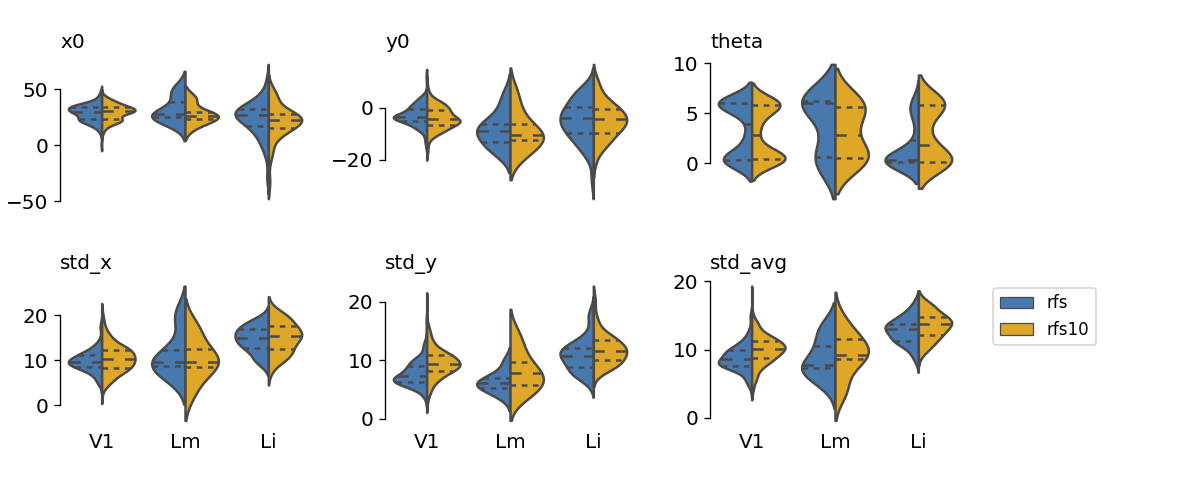

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10_2', 'all-metrics_cells-common-to-both-condns_std')


In [77]:
currcols = ['windows blue', 'amber']
bi_palette = sns.xkcd_palette(currcols)

fig, axes = pl.subplots(2, 3, figsize=(10,4), dpi=dpi)
fig.patch.set_alpha(0)

for ai, (ax, param) in enumerate(zip(axes.flat, params)):
    sns.violinplot(x='visual_area', y=param, data=comdf, ax=ax,
                   order=visual_areas,
                  hue='experiment', palette=bi_palette, split=True,
                   scale='count', inner='quartile')
    if ai < 5:
        ax.legend_.remove()
    else:
        ax.legend(bbox_to_anchor=(1.1, 1))
    if ai<3:
        ax.set_xticklabels('')
    ax.set_xlabel('')
    ax.tick_params(axis='x', size=0)
    sns.despine(trim=True, ax=ax, bottom=True)
    ax.set_ylabel('')
    ax.set_title(param, fontsize=12, loc='left')
    
pl.subplots_adjust(wspace=0.3, hspace=0.5, right=0.8, left=0.05)


# Save
figname = 'all-metrics_cells-common-to-both-condns_%s' % sz_metric
pl.savefig(os.path.join(compare_dir, '%s_2svg' % figname))

print(compare_dir, figname)    

In [52]:
reload(aggr)
reload(ret)

<module 'pipeline.python.classifications.retino_structure' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/retino_structure.pyc'>

# Visualize general stats

In [53]:
scale_sigma = True


### Check size distns for ALL dataset

In [78]:
# set output dir
filter_by = 'drop_repeats'
genstats_dir = os.path.join(outdir, 'general-stats', filter_by)
if not os.path.exists(genstats_dir):
    os.makedirs(genstats_dir)
print genstats_dir

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats


In [79]:
reliable_only

True

In [80]:
filter_by = None
reliable_only = True

#### Get metadata
r_df_nof, dkey_dict_nof = rfutils.aggregate_rf_dataframes(filter_by, traceid=traceid, 
                                                          fit_desc='fit-2dgaus_dff-no-cutoff',
                                                          reliable_only=reliable_only,
                                                          fov_type=fov_type, state=state, stimulus='rfs')

# dsets_nof = aggr.get_metadata(traceid=traceid, fov_type=fov_type, state=state, 
#                               filter_by=filter_by, stimulus='rfs')
# rfdata_nof = dsets_nof[dsets_nof['experiment'].isin(['rfs', 'rfs10'])].copy()

# #### Check for any datasets that need RF fits
# excluded_sessions = ['JC110_20191004_FOV1_zoom2p0x',
#                      'JC080_20190602_FOV1_zoom2p0x',
#                      'JC113_20191108_FOV1_zoom2p0x', 'JC113_20191108_FOV2_zoom2p0x']
# rf_dpaths_nof, _ = rfutils.get_fit_dpaths(rfdata_nof, traceid=traceid, fit_desc=fit_desc, 
#                                           excluded_sessions=excluded_sessions)

# #### Get RF dataframe for all datasets (filter to include only good fits)
# all_df_nof = rfutils.aggregate_rf_data(rf_dpaths_nof, scale_sigma=scale_sigma, verbose=False,
#                                       fit_desc=fit_desc, traceid=traceid)
# all_df_nof.groupby(['visual_area', 'experiment'])['datakey'].count()

# #### Filter for good fits only
# r_df_nof= all_df_nof[all_df_nof['rvisual_areas = ['V1', 'Lm', 'Li']
# colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
# area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}
# 2'] > fit_thr].copy().reset_index(drop=True)
# dkey_dict_nof = dict((v, dict((dk, di) for di, dk in enumerate(vdf['datakey'].unique()))) \
#                  for v, vdf in r_df_nof.groupby(['visual_area'])) 
# r_df_nof['datakey_ix'] = [dkey_dict_nof[r_df_nof['visual_area'][i]][r_df_nof['datakey'][i]] \
#                       for i in r_df_nof.index.tolist()]    
    
    

Selecting 63 dsets
N dpaths: 70, N unfit: 0
N datasets included: 70, N sessions excluded: 4


<IPython.core.display.Javascript object>


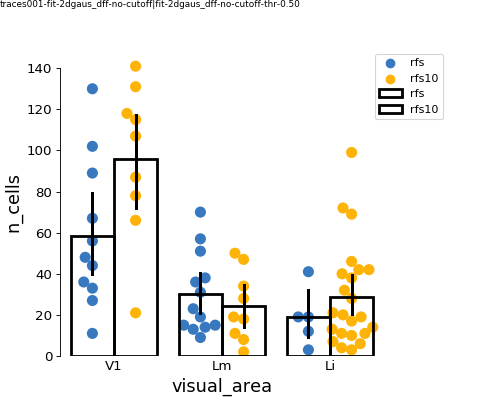

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10_2', 'N_cells_fit_by_area_ALL')


In [81]:
r_df_nof
countdf_all = r_df_nof.groupby([ 'experiment', 'visual_area', 'animalid', 'datakey']).count()['cell'].reset_index()
countdf_all.rename(columns={'cell': 'n_cells'}, inplace=True)


curr_metric = 'n_cells'

# g = sns.catplot(x='visual_area', hue='experiment',y='n_cells', data=countdf_all, 
#             kind='swarm', dodge=True, palette=bi_palette)
# Set x labels
fig, ax = pl.subplots(figsize=(6,5))
sns.swarmplot(x='visual_area', y='n_cells', hue='experiment', data=countdf_all, 
              dodge=True, palette=bi_palette, ax=ax, size=10, zorder=0,
             order=['V1', 'Lm', 'Li'])
sns.barplot(x='visual_area', y='n_cells', hue='experiment', data=countdf_all, ax=ax,
              facecolor=(1, 1, 1, 0), order=['V1', 'Lm', 'Li'],
            errcolor="k", edgecolor=('k', 'k', 'k'), linewidth=2.5)
sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)
label_figure(fig, data_id)
pl.legend(bbox_to_anchor=((1.2, 1)))
pl.subplots_adjust(right=0.8)


figname = 'N_cells_fit_by_area_ALL'
pl.savefig(os.path.join(compare_dir, '%s.svg' % figname))
print(compare_dir, figname)


In [60]:
genstats_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats'

<IPython.core.display.Javascript object>


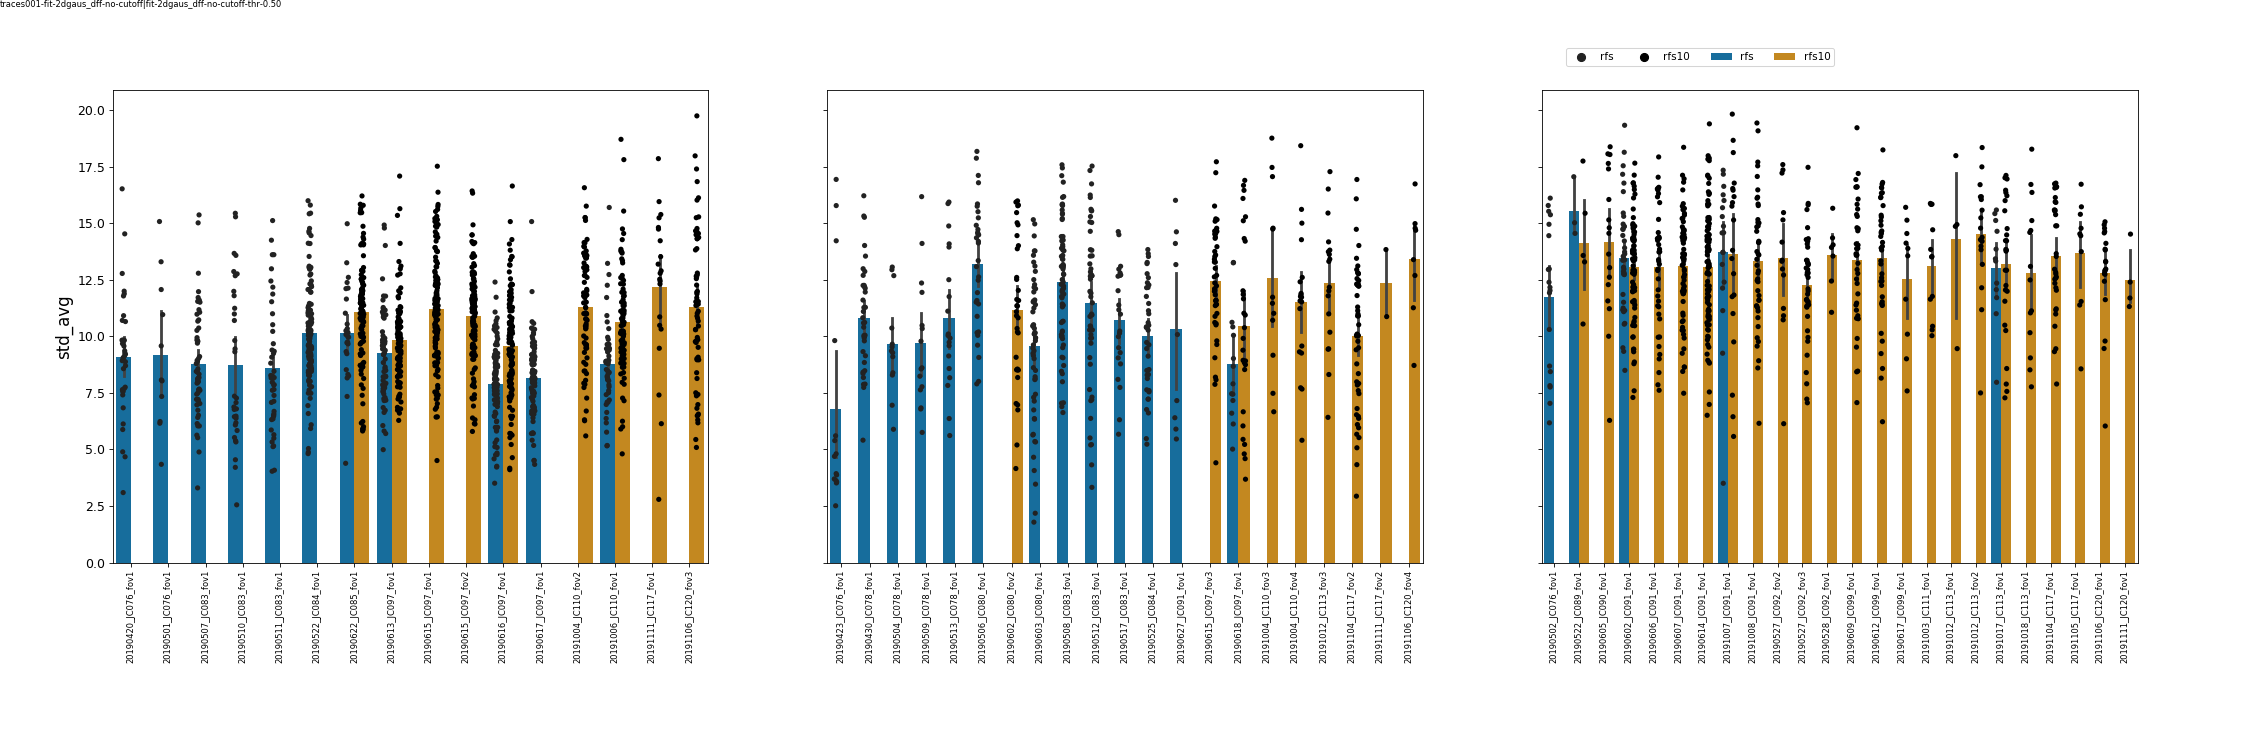

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats', 'std_avg_by-dataset_by-experiment_ALL')


In [64]:

sz_metric = 'std'
curr_metric = '%s_avg' % sz_metric

fig, axes = pl.subplots(1,3, figsize=(30, 10), sharey=True)
for ai, (ax, visual_area) in enumerate(zip(axes.flat, visual_areas)):
    
    plotdf = r_df_nof[r_df_nof['visual_area']==visual_area]
    curr_datakeys = sorted(plotdf['datakey'].unique(), key=natural_keys)
    
    #xvs = [dkey_dict[dk] for dk in curr_datakeys]
    plotdf['xv'] = [dkey_dict_nof[visual_area][dk] for dk in plotdf['datakey']]
    
    sns.stripplot(x='xv', y=curr_metric, hue='experiment', data=plotdf, ax=ax,
                 dodge=True, color='k')
    
    sns.barplot(x='xv', y=curr_metric, hue='experiment', data=plotdf, ax=ax,
                 palette='colorblind')
    
    dkey_labels = [dk for dk, di in sorted(dkey_dict_nof[visual_area].items(), key=lambda x: x[1])]
    
    ax.set_xticklabels(dkey_labels, rotation=90, fontsize=8)
    ax.set_xlabel('')
    if ai != 0:
        ax.set_ylabel('')
        
    if ai != 2:
        ax.legend_.remove()
    else:
        ax.legend(bbox_to_anchor=(0.5, 1.1), ncol=4)
pl.subplots_adjust(bottom=0.25, left=0.05, right=0.95, wspace=0.2)

label_figure(fig, data_id)
figname = '%s_by-dataset_by-experiment_ALL' % (curr_metric)
pl.savefig(os.path.join(outdir, 'general-stats', '%s.svg' % figname))
print(genstats_dir, figname)

# PW distances

In [88]:
from pipeline.python.rois.utils import load_roi_coords

In [199]:
compare_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10_2'

In [89]:
get_positions = False

reliable_str = 'reliable' if reliable_only else 'allfit'
df_fpath = os.path.join(outdir, 'fits_and_coords_%s_%s.pkl' % (filter_by, reliable_str))
print(df_fpath)

# Check if exists and load
if os.path.exists(df_fpath) or get_positions is False:
    print("Loading existing RF coord conversions...")
    try:
        with open(df_fpath, 'rb') as f:
            df = pkl.load(f)
    except Exception as e:
        print(e)
        get_positions = True
print(get_positions)


/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_None_reliable.pkl
Loading existing RF coord conversions...
[Errno 2] No such file or directory: '/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_None_reliable.pkl'
True


In [91]:
df = r_df_nof.copy()
if get_positions:
    print("Calculating RF coord conversions...")
    pos_params = ['fov_xpos', 'fov_xpos_pix', 'fov_ypos', 'fov_ypos_pix', 'ml_pos','ap_pos']
    for p in pos_params:
        df[p] = ''
    p_list=[]
    for (experiment, animalid, session, fovnum), g in df.groupby(['experiment', 'animalid', 'session', 'fovnum']):
        cell_ids = g['cell'].unique()
        fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                                  traceid=traceid, create_new=False)
        p_ = fcoords['roi_positions'].loc[cell_ids]
        for p in pos_params:
            df[p][g.index] = p_[p]

    with open(df_fpath, 'wb') as f:
        pkl.dump({'df': df}, f, protocol=pkl.HIGHEST_PROTOCOL)
    

Calculating RF coord conversions...
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coord

In [92]:
df.head()

,r2,fwhm_x,fwhm_y,theta,x0,y0,animalid,cell,datakey,experiment,...,fwhm_avg,std_avg,area,datakey_ix,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
0,0.826039,23.640365,13.125770,0.117896,6.700889,-8.282818,JC076,0,20190502_JC076_fov1,rfs,...,18.383068,7.822582,176.519678,0,85.2665,37,218.928,115,753.872,1092.33
1,0.725070,43.796452,29.207447,0.234407,-22.165338,-2.970096,JC076,84,20190502_JC076_fov1,rfs,...,36.501949,15.532744,727.690433,0,638.347,277,605.382,318,367.418,539.253
2,0.701576,47.503138,24.790225,0.458457,15.301437,31.251545,JC076,115,20190502_JC076_fov1,rfs,...,36.146682,15.381567,669.910720,0,1034.72,449,788.139,414,184.661,142.879
3,0.781400,23.130716,44.809417,0.155088,2.496442,37.699467,JC076,120,20190502_JC076_fov1,rfs,...,33.970067,14.455348,589.620427,0,956.368,415,761.487,400,211.313,221.232
4,0.627347,32.132070,25.065036,5.892774,0.014677,17.244112,JC076,135,20190502_JC076_fov1,rfs,...,28.598553,12.169597,458.164233,0,1115.38,484,740.546,389,232.254,62.2215


### Calculate pw distances between RF positions and FOV positions

In [94]:
min_cells = 5

pair_names = [('fov_x', 'ml_pos'), ('fov_y', 'ap_pos'), ('rf_x', 'x0'), ('rf_y', 'y0')]

d_list = []
# Get all pairwise distances between rf positions:
for (experiment, visual_area, animalid, session, fovnum), g in df.groupby(['experiment', 'visual_area', 'animalid', 'session', 'fovnum']):
    if g.shape[0] <= min_cells:
        continue
        
    diffs={}
    for (d1, d2) in pair_names:
        xx = g[d2].values
        diffs[d1] = np.abs([t1-t2 for i, t1 in enumerate(xx) for t2 in xx[i + 1:]])
        npairs = len(list(itertools.combinations(range(len(xx)), 2)))
        assert len(diffs[d1]) == npairs, "bad combos"

    d_df = pd.DataFrame(diffs)
    d_df['animalid'] = [animalid for _ in np.arange(0, npairs)]
    d_df['session'] = [session for _ in np.arange(0, npairs)]
    d_df['fovnum'] = [fovnum for _ in np.arange(0, npairs)]
    d_df['visual_area'] = [visual_area for _ in np.arange(0, npairs)]
    d_df['datakey'] = ['%s_%s_fov%i' % (session, animalid, fovnum) for _ in np.arange(0, npairs)]
    d_df['experiment'] = [experiment for _ in np.arange(0, npairs)]
    d_list.append(d_df)
    
diff_df = pd.concat(d_list, axis=0).reset_index(drop=True)

## Calculate rate of relative change

In [95]:
from pipeline.python.classifications import evaluate_receptivefield_fits as evalrf
from sklearn.linear_model import LinearRegression
import scipy.stats as spstats
import sklearn.metrics as skmetrics #import mean_squared_error

In [135]:
# Plot regression w/ CI
xvar = 'fov'
yvar = 'rf'
d_list=[]
i=0
for (visual_area, animalid, session, fovnum, datakey, experiment), currdf in diff_df.groupby(
                                    ['visual_area', 'animalid', 'session', 'fovnum', 'datakey', 'experiment']):
    for axi in ['x', 'y']:
        
        xv = currdf['fov_%s' % axi].values
        yv = currdf['rf_%s' % axi].values
        
        fitv, regr = evalrf.fit_linear_regr(xv, yv, return_regr=True)
        # ax.plot(xv, fitv, curr_color)
        rmse = np.sqrt(skmetrics.mean_squared_error(yv, fitv))
        r2 = skmetrics.r2_score(yv, fitv)
        pearson_p, pearson_r = spstats.pearsonr(xv, yv)
            
        
        tmpdf = pd.DataFrame({'slope': float(regr.coef_),
                              'R2': r2,
                              'RMSE': rmse,
                              'axis': axi,
                              'pearson_p': pearson_p,
                              'pearson_r': pearson_r,
                              'n_cells': df[df['datakey']==datakey].shape[0], #len(yv),
                              'animalid': animalid, 'session': session, 'fovnum': fovnum,
                              'visual_area': visual_area,
                              'experiment': experiment,
                              'datakey': '%s_%s_fov%i' % (session, animalid, fovnum)}, index=[i])
        
        d_list.append(tmpdf)
        i+=1
pwslopes = pd.concat(d_list, axis=0).reset_index(drop=True)

In [138]:
pwslopes[pwslopes['R2'] >= R2_thr].groupby(['visual_area', 'experiment']).count()

R2  RMSE  animalid  axis  datakey  fovnum  n_cells  \
visual_area experiment                                                       
Li          rfs          5     5         5     5        5       5        5   
            rfs10       21    21        21    21       21      21       21   
Lm          rfs         21    21        21    21       21      21       21   
            rfs10        4     4         4     4        4       4        4   
V1          rfs         20    20        20    20       20      20       20   
            rfs10       12    12        12    12       12      12       12   

                        pearson_p  pearson_r  session  slope  
visual_area experiment                                        
Li          rfs                 5          5        5      5  
            rfs10              21         21       21     21  
Lm          rfs                21         21       21     21  
            rfs10               4          4        4      4  
V1          rfs                20         20       20     20  
            rfs10              12         12       12     12

<IPython.core.display.Javascript object>


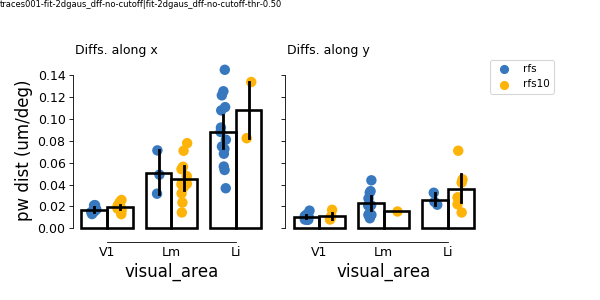

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10_2', 'slope_regr_pw_distances_rfpos_vs_fovpos_split_xy_R2-0.20')


In [201]:
metric = 'slope'
fig, axn = pl.subplots(1, 2, sharex=True, sharey=True, figsize=(8,4))

R2_thr = 0.2
thr_str = 'R2-%.2f' % R2_thr
curr_df = pwslopes[pwslopes['R2'] >= R2_thr]

for ax, axi in zip(axn.flat, ['x', 'y']):
    
    axdf = curr_df[(curr_df['axis']==axi)].copy()
    
    sns.stripplot(x='visual_area', y=metric, hue='experiment', data=axdf, 
                  dodge=True, palette=bi_palette, ax=ax, size=10, zorder=0,
                 order=['V1', 'Lm', 'Li'])
    sns.barplot(x='visual_area', y=metric, hue='experiment', data=axdf, ax=ax,
                  facecolor=(1, 1, 1, 0), order=['V1', 'Lm', 'Li'],
                errcolor="k", edgecolor=('k', 'k', 'k'), linewidth=2.5)
    
    sns.despine(bottom=True, trim=True)
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_title('Diffs. along %s' % axi, loc='left')
    ax.set_ylabel('')

    if axi == 'x':
        ax.legend_.remove()
    else:
        # Get the handles and labels. For this example it'll be 2 tuples
        # of length 4 each.
        handles, labels = ax.get_legend_handles_labels()

        # When creating the legend, only use the first two elements
        # to effectively remove the last two.
        l = pl.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

axn[0].set_ylabel('pw dist (um/deg)')

sns.despine(trim=True, offset=2)
pl.subplots_adjust(wspace=0.1, right=0.8, top=0.8, bottom=0.2)


label_figure(fig, data_id)

figname = '%s_regr_pw_distances_rfpos_vs_fovpos_split_xy_%s' % (metric, thr_str)
pl.savefig(os.path.join(compare_dir, '%s.svg' % figname))
print(compare_dir, figname)